In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

# Raw code
  - paper's code

In [2]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > {}:".format(max_len),long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)  # padding
    return data,torch.tensor(labels)

In [3]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(4050,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive
    
    
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2
    

* model architecture

In [4]:
data,label=genData("compareModel/2021ACS_PepFormer/dataset/Homo_sapiens.csv",81)
print(data.shape,label.shape)

train_data,train_label=data[:70000],label[:70000]
test_data,test_label=data[70000:],label[70000:]

train_dataset = Data.TensorDataset(train_data, train_label)
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)

length > 81: 0
torch.Size([90000, 79]) torch.Size([90000])


In [5]:
device = torch.device("cuda",0)
model = newModel().to(device)

print(model)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('total param cnt : {:,}'.format(params))

newModel(
  (embedding): Embedding(24, 512, padding_idx=0)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=Fals

* model evaluation

In [8]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

In [9]:
for num_model in range(10):
    net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(test_iter,net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
#         to_log(results)
        if test_acc>best_acc:
            best_acc=test_acc
#             torch.save({"best_acc":best_acc,"model":net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 181.31001, loss1: 2.54977, loss2_3: 178.76024
	train_acc: 0.5275, test_acc: 0.5252, time: 36.03
best_acc: 0.5252
epoch: 2, loss: 176.02166, loss1: 1.02241, loss2_3: 174.99925
	train_acc: 0.5453, test_acc: 0.5433, time: 36.42
best_acc: 0.5433
epoch: 3, loss: 170.48735, loss1: 1.02546, loss2_3: 169.46189
	train_acc: 0.6366, test_acc: 0.63205, time: 36.40
best_acc: 0.63205
epoch: 4, loss: 147.53434, loss1: 0.99737, loss2_3: 146.53697
	train_acc: 0.7145, test_acc: 0.71295, time: 36.45
best_acc: 0.71295
epoch: 5, loss: 135.65731, loss1: 0.97018, loss2_3: 134.68713
	train_acc: 0.7490, test_acc: 0.74845, time: 36.47
best_acc: 0.74845
epoch: 6, loss: 132.02680, loss1: 0.95435, loss2_3: 131.07244
	train_acc: 0.7395, test_acc: 0.7388, time: 36.50
epoch: 7, loss: 130.36009, loss1: 0.93608, loss2_3: 129.42402
	train_acc: 0.7538, test_acc: 0.75435, time: 36.51
best_acc: 0.75435
epoch: 8, loss: 129.20100, loss1: 0.94109, loss2_3: 128.25991
	train_acc: 0.7548, test_acc: 0.75585, time:

epoch: 66, loss: 115.37742, loss1: 0.84335, loss2_3: 114.53408
	train_acc: 0.8020, test_acc: 0.7991, time: 36.34
epoch: 67, loss: 115.33950, loss1: 0.84454, loss2_3: 114.49496
	train_acc: 0.8012, test_acc: 0.7983, time: 36.27
epoch: 68, loss: 115.33733, loss1: 0.84454, loss2_3: 114.49279
	train_acc: 0.8030, test_acc: 0.7986, time: 36.35
epoch: 69, loss: 115.23097, loss1: 0.83745, loss2_3: 114.39352
	train_acc: 0.8020, test_acc: 0.7989, time: 36.26
epoch: 70, loss: 115.06869, loss1: 0.84343, loss2_3: 114.22526
	train_acc: 0.8014, test_acc: 0.79935, time: 36.32
epoch: 71, loss: 114.86291, loss1: 0.83919, loss2_3: 114.02372
	train_acc: 0.8038, test_acc: 0.8007, time: 36.39
best_acc: 0.8007
epoch: 72, loss: 115.07691, loss1: 0.83774, loss2_3: 114.23917
	train_acc: 0.7967, test_acc: 0.7926, time: 36.62
epoch: 73, loss: 114.43407, loss1: 0.84365, loss2_3: 113.59042
	train_acc: 0.8039, test_acc: 0.8016, time: 36.60
best_acc: 0.8016
epoch: 74, loss: 114.65314, loss1: 0.84187, loss2_3: 113.8112

epoch: 132, loss: 110.29523, loss1: 0.81712, loss2_3: 109.47811
	train_acc: 0.8137, test_acc: 0.8008, time: 36.34
epoch: 133, loss: 110.22239, loss1: 0.81547, loss2_3: 109.40693
	train_acc: 0.8133, test_acc: 0.80095, time: 36.28
epoch: 134, loss: 109.97700, loss1: 0.81109, loss2_3: 109.16591
	train_acc: 0.8075, test_acc: 0.79905, time: 36.29
epoch: 135, loss: 109.94794, loss1: 0.81106, loss2_3: 109.13688
	train_acc: 0.8128, test_acc: 0.80285, time: 36.30
epoch: 136, loss: 109.86472, loss1: 0.81372, loss2_3: 109.05100
	train_acc: 0.8110, test_acc: 0.8008, time: 36.27
epoch: 137, loss: 109.58782, loss1: 0.81357, loss2_3: 108.77425
	train_acc: 0.8140, test_acc: 0.80215, time: 36.29
epoch: 138, loss: 109.68763, loss1: 0.81622, loss2_3: 108.87141
	train_acc: 0.8115, test_acc: 0.8021, time: 36.27
epoch: 139, loss: 109.67825, loss1: 0.81371, loss2_3: 108.86454
	train_acc: 0.8072, test_acc: 0.79225, time: 36.30
epoch: 140, loss: 109.72257, loss1: 0.81342, loss2_3: 108.90915
	train_acc: 0.8157,

epoch: 199, loss: 102.63043, loss1: 0.78510, loss2_3: 101.84533
	train_acc: 0.8308, test_acc: 0.79855, time: 36.26
epoch: 200, loss: 102.53651, loss1: 0.78422, loss2_3: 101.75229
	train_acc: 0.8223, test_acc: 0.79815, time: 36.28
epoch: 201, loss: 102.35170, loss1: 0.78987, loss2_3: 101.56183
	train_acc: 0.8284, test_acc: 0.79895, time: 36.29
epoch: 202, loss: 102.12463, loss1: 0.78497, loss2_3: 101.33966
	train_acc: 0.8338, test_acc: 0.79535, time: 36.27
epoch: 203, loss: 101.73831, loss1: 0.78592, loss2_3: 100.95239
	train_acc: 0.8252, test_acc: 0.79925, time: 36.27
epoch: 204, loss: 101.61346, loss1: 0.78400, loss2_3: 100.82945
	train_acc: 0.8347, test_acc: 0.79965, time: 36.27
epoch: 205, loss: 101.54796, loss1: 0.77963, loss2_3: 100.76833
	train_acc: 0.8253, test_acc: 0.79715, time: 36.27
epoch: 206, loss: 101.34622, loss1: 0.78579, loss2_3: 100.56043
	train_acc: 0.8346, test_acc: 0.8005, time: 36.25
epoch: 207, loss: 101.09353, loss1: 0.78455, loss2_3: 100.30898
	train_acc: 0.834

epoch: 16, loss: 122.64707, loss1: 0.90378, loss2_3: 121.74329
	train_acc: 0.7840, test_acc: 0.78425, time: 36.43
best_acc: 0.78425
epoch: 17, loss: 122.18648, loss1: 0.89128, loss2_3: 121.29520
	train_acc: 0.7788, test_acc: 0.77695, time: 36.39
epoch: 18, loss: 122.72890, loss1: 0.89950, loss2_3: 121.82939
	train_acc: 0.7853, test_acc: 0.78425, time: 36.47
epoch: 19, loss: 121.40967, loss1: 0.89217, loss2_3: 120.51750
	train_acc: 0.7782, test_acc: 0.7782, time: 36.39
epoch: 20, loss: 121.76388, loss1: 0.89309, loss2_3: 120.87079
	train_acc: 0.7826, test_acc: 0.7814, time: 36.45
epoch: 21, loss: 121.24577, loss1: 0.88203, loss2_3: 120.36374
	train_acc: 0.7906, test_acc: 0.79115, time: 36.65
best_acc: 0.79115
epoch: 22, loss: 120.61898, loss1: 0.88574, loss2_3: 119.73324
	train_acc: 0.7866, test_acc: 0.7841, time: 37.36
epoch: 23, loss: 120.95050, loss1: 0.88563, loss2_3: 120.06487
	train_acc: 0.7815, test_acc: 0.78345, time: 36.71
epoch: 24, loss: 120.88696, loss1: 0.89071, loss2_3: 11

epoch: 82, loss: 113.98213, loss1: 0.83234, loss2_3: 113.14978
	train_acc: 0.8052, test_acc: 0.8007, time: 36.30
epoch: 83, loss: 113.87083, loss1: 0.83930, loss2_3: 113.03153
	train_acc: 0.7997, test_acc: 0.79375, time: 36.23
epoch: 84, loss: 113.82954, loss1: 0.83300, loss2_3: 112.99654
	train_acc: 0.8058, test_acc: 0.8027, time: 36.26
best_acc: 0.8027
epoch: 85, loss: 113.83339, loss1: 0.83688, loss2_3: 112.99651
	train_acc: 0.8017, test_acc: 0.7967, time: 36.25
epoch: 86, loss: 114.14336, loss1: 0.83437, loss2_3: 113.30899
	train_acc: 0.8048, test_acc: 0.80065, time: 36.27
epoch: 87, loss: 113.86717, loss1: 0.83586, loss2_3: 113.03131
	train_acc: 0.8042, test_acc: 0.8001, time: 36.22
epoch: 88, loss: 113.48967, loss1: 0.82834, loss2_3: 112.66133
	train_acc: 0.8035, test_acc: 0.79775, time: 36.28
epoch: 89, loss: 113.50384, loss1: 0.83455, loss2_3: 112.66928
	train_acc: 0.8064, test_acc: 0.80245, time: 36.21
epoch: 90, loss: 113.62574, loss1: 0.82937, loss2_3: 112.79638
	train_acc: 

epoch: 148, loss: 109.39500, loss1: 0.81581, loss2_3: 108.57919
	train_acc: 0.8165, test_acc: 0.80405, time: 36.24
epoch: 149, loss: 109.31931, loss1: 0.81792, loss2_3: 108.50139
	train_acc: 0.8159, test_acc: 0.80305, time: 36.23
epoch: 150, loss: 109.14573, loss1: 0.80999, loss2_3: 108.33574
	train_acc: 0.8170, test_acc: 0.8022, time: 36.26
epoch: 151, loss: 109.22863, loss1: 0.81115, loss2_3: 108.41748
	train_acc: 0.8145, test_acc: 0.80155, time: 36.22
epoch: 152, loss: 109.05321, loss1: 0.81310, loss2_3: 108.24011
	train_acc: 0.8157, test_acc: 0.80065, time: 36.27
epoch: 153, loss: 108.69429, loss1: 0.81207, loss2_3: 107.88222
	train_acc: 0.8173, test_acc: 0.80085, time: 36.22
epoch: 154, loss: 108.43033, loss1: 0.81063, loss2_3: 107.61970
	train_acc: 0.8095, test_acc: 0.7907, time: 36.25
epoch: 155, loss: 108.48127, loss1: 0.80936, loss2_3: 107.67191
	train_acc: 0.8180, test_acc: 0.8001, time: 36.22
epoch: 156, loss: 108.31966, loss1: 0.80746, loss2_3: 107.51219
	train_acc: 0.8189,

epoch: 215, loss: 101.52764, loss1: 0.78540, loss2_3: 100.74224
	train_acc: 0.8322, test_acc: 0.7878, time: 36.20
epoch: 216, loss: 101.56752, loss1: 0.78501, loss2_3: 100.78251
	train_acc: 0.8358, test_acc: 0.7994, time: 36.23
epoch: 217, loss: 101.09031, loss1: 0.78377, loss2_3: 100.30653
	train_acc: 0.8351, test_acc: 0.7993, time: 36.20
epoch: 218, loss: 101.39153, loss1: 0.78967, loss2_3: 100.60186
	train_acc: 0.8354, test_acc: 0.7922, time: 36.26
epoch: 219, loss: 100.60394, loss1: 0.78445, loss2_3: 99.81949
	train_acc: 0.8351, test_acc: 0.79915, time: 36.21
epoch: 220, loss: 100.89512, loss1: 0.78345, loss2_3: 100.11167
	train_acc: 0.8378, test_acc: 0.79565, time: 36.26
epoch: 221, loss: 100.70584, loss1: 0.78303, loss2_3: 99.92281
	train_acc: 0.8293, test_acc: 0.7983, time: 36.20
epoch: 222, loss: 100.08516, loss1: 0.78109, loss2_3: 99.30407
	train_acc: 0.8397, test_acc: 0.79425, time: 36.22
epoch: 223, loss: 99.94210, loss1: 0.78328, loss2_3: 99.15882
	train_acc: 0.8343, test_a

epoch: 31, loss: 119.70125, loss1: 0.87514, loss2_3: 118.82610
	train_acc: 0.7933, test_acc: 0.7924, time: 36.35
best_acc: 0.7924
epoch: 32, loss: 119.62094, loss1: 0.87733, loss2_3: 118.74361
	train_acc: 0.7871, test_acc: 0.7875, time: 36.42
epoch: 33, loss: 119.13628, loss1: 0.87109, loss2_3: 118.26520
	train_acc: 0.7858, test_acc: 0.7845, time: 36.34
epoch: 34, loss: 119.02014, loss1: 0.86648, loss2_3: 118.15366
	train_acc: 0.7910, test_acc: 0.78905, time: 36.38
epoch: 35, loss: 118.96418, loss1: 0.87010, loss2_3: 118.09408
	train_acc: 0.7920, test_acc: 0.79135, time: 36.36
epoch: 36, loss: 119.02294, loss1: 0.87279, loss2_3: 118.15015
	train_acc: 0.7960, test_acc: 0.795, time: 36.35
best_acc: 0.795
epoch: 37, loss: 118.34633, loss1: 0.87047, loss2_3: 117.47586
	train_acc: 0.7934, test_acc: 0.79235, time: 36.36
epoch: 38, loss: 118.67796, loss1: 0.86700, loss2_3: 117.81096
	train_acc: 0.7940, test_acc: 0.79365, time: 36.34
epoch: 39, loss: 118.67769, loss1: 0.86815, loss2_3: 117.809

epoch: 97, loss: 113.87403, loss1: 0.83511, loss2_3: 113.03891
	train_acc: 0.8057, test_acc: 0.8029, time: 36.25
epoch: 98, loss: 114.30896, loss1: 0.84103, loss2_3: 113.46793
	train_acc: 0.8055, test_acc: 0.80225, time: 36.26
epoch: 99, loss: 113.65236, loss1: 0.82609, loss2_3: 112.82627
	train_acc: 0.8052, test_acc: 0.80235, time: 36.26
epoch: 100, loss: 113.47488, loss1: 0.82921, loss2_3: 112.64567
	train_acc: 0.8060, test_acc: 0.80175, time: 36.23
epoch: 101, loss: 113.37569, loss1: 0.82528, loss2_3: 112.55041
	train_acc: 0.8048, test_acc: 0.7998, time: 36.25
epoch: 102, loss: 113.50034, loss1: 0.83631, loss2_3: 112.66403
	train_acc: 0.8049, test_acc: 0.7994, time: 36.25
epoch: 103, loss: 113.28999, loss1: 0.83219, loss2_3: 112.45780
	train_acc: 0.8059, test_acc: 0.8018, time: 36.21
epoch: 104, loss: 113.64028, loss1: 0.83062, loss2_3: 112.80966
	train_acc: 0.8053, test_acc: 0.8008, time: 36.28
epoch: 105, loss: 113.45271, loss1: 0.82711, loss2_3: 112.62560
	train_acc: 0.8066, test

epoch: 164, loss: 109.14239, loss1: 0.81114, loss2_3: 108.33125
	train_acc: 0.8162, test_acc: 0.8025, time: 36.23
epoch: 165, loss: 109.25859, loss1: 0.80986, loss2_3: 108.44873
	train_acc: 0.8152, test_acc: 0.8043, time: 36.26
best_acc: 0.8043
epoch: 166, loss: 108.81253, loss1: 0.80598, loss2_3: 108.00655
	train_acc: 0.8157, test_acc: 0.80155, time: 36.25
epoch: 167, loss: 109.00570, loss1: 0.80892, loss2_3: 108.19678
	train_acc: 0.8137, test_acc: 0.8021, time: 36.24
epoch: 168, loss: 108.75589, loss1: 0.80951, loss2_3: 107.94638
	train_acc: 0.8116, test_acc: 0.8001, time: 36.28
epoch: 169, loss: 108.66635, loss1: 0.80739, loss2_3: 107.85896
	train_acc: 0.8132, test_acc: 0.8014, time: 36.23
epoch: 170, loss: 108.62761, loss1: 0.81017, loss2_3: 107.81745
	train_acc: 0.8148, test_acc: 0.80185, time: 36.28
epoch: 171, loss: 108.59571, loss1: 0.81072, loss2_3: 107.78499
	train_acc: 0.8156, test_acc: 0.8005, time: 36.21
epoch: 172, loss: 108.30903, loss1: 0.80388, loss2_3: 107.50516
	trai

epoch: 231, loss: 103.09965, loss1: 0.79556, loss2_3: 102.30409
	train_acc: 0.8228, test_acc: 0.79655, time: 36.18
epoch: 232, loss: 102.80315, loss1: 0.78423, loss2_3: 102.01892
	train_acc: 0.8281, test_acc: 0.80125, time: 36.21
epoch: 233, loss: 102.72218, loss1: 0.78945, loss2_3: 101.93273
	train_acc: 0.8344, test_acc: 0.7952, time: 36.15
epoch: 234, loss: 102.58321, loss1: 0.79152, loss2_3: 101.79168
	train_acc: 0.8270, test_acc: 0.7991, time: 36.22
epoch: 235, loss: 102.18960, loss1: 0.79248, loss2_3: 101.39712
	train_acc: 0.8328, test_acc: 0.79975, time: 36.20
epoch: 236, loss: 102.20759, loss1: 0.78688, loss2_3: 101.42071
	train_acc: 0.8266, test_acc: 0.7974, time: 36.22
epoch: 237, loss: 102.54085, loss1: 0.78643, loss2_3: 101.75442
	train_acc: 0.8270, test_acc: 0.78815, time: 36.17
epoch: 238, loss: 102.39317, loss1: 0.78774, loss2_3: 101.60543
	train_acc: 0.8313, test_acc: 0.79715, time: 36.25
epoch: 239, loss: 102.24855, loss1: 0.78687, loss2_3: 101.46168
	train_acc: 0.8321,

epoch: 46, loss: 117.35743, loss1: 0.86081, loss2_3: 116.49662
	train_acc: 0.7950, test_acc: 0.7949, time: 36.43
epoch: 47, loss: 116.94248, loss1: 0.85744, loss2_3: 116.08504
	train_acc: 0.7973, test_acc: 0.79555, time: 36.37
epoch: 48, loss: 117.76854, loss1: 0.86474, loss2_3: 116.90380
	train_acc: 0.7990, test_acc: 0.79765, time: 36.39
best_acc: 0.79765
epoch: 49, loss: 117.11386, loss1: 0.85550, loss2_3: 116.25836
	train_acc: 0.7975, test_acc: 0.79695, time: 36.39
epoch: 50, loss: 117.06362, loss1: 0.85991, loss2_3: 116.20370
	train_acc: 0.7983, test_acc: 0.799, time: 36.38
best_acc: 0.799
epoch: 51, loss: 117.01552, loss1: 0.85469, loss2_3: 116.16082
	train_acc: 0.7965, test_acc: 0.7946, time: 36.37
epoch: 52, loss: 117.15135, loss1: 0.86097, loss2_3: 116.29038
	train_acc: 0.7963, test_acc: 0.7967, time: 36.38
epoch: 53, loss: 116.70837, loss1: 0.85774, loss2_3: 115.85063
	train_acc: 0.7940, test_acc: 0.79415, time: 36.33
epoch: 54, loss: 116.74509, loss1: 0.85989, loss2_3: 115.88

epoch: 112, loss: 112.64620, loss1: 0.82840, loss2_3: 111.81780
	train_acc: 0.8021, test_acc: 0.79765, time: 37.30
epoch: 113, loss: 112.64784, loss1: 0.82532, loss2_3: 111.82253
	train_acc: 0.8084, test_acc: 0.80165, time: 36.65
epoch: 114, loss: 112.62025, loss1: 0.82324, loss2_3: 111.79701
	train_acc: 0.8091, test_acc: 0.80175, time: 36.26
epoch: 115, loss: 112.77412, loss1: 0.82509, loss2_3: 111.94903
	train_acc: 0.8061, test_acc: 0.80085, time: 36.27
epoch: 116, loss: 112.51144, loss1: 0.82734, loss2_3: 111.68410
	train_acc: 0.8077, test_acc: 0.8024, time: 36.31
epoch: 117, loss: 112.64294, loss1: 0.82426, loss2_3: 111.81868
	train_acc: 0.8075, test_acc: 0.80015, time: 36.27
epoch: 118, loss: 112.38562, loss1: 0.82100, loss2_3: 111.56462
	train_acc: 0.8079, test_acc: 0.80295, time: 36.32
epoch: 119, loss: 112.37515, loss1: 0.82210, loss2_3: 111.55305
	train_acc: 0.8082, test_acc: 0.80345, time: 36.24
best_acc: 0.80345
epoch: 120, loss: 112.26277, loss1: 0.82251, loss2_3: 111.44026

epoch: 179, loss: 107.87598, loss1: 0.80417, loss2_3: 107.07181
	train_acc: 0.8180, test_acc: 0.8018, time: 36.25
epoch: 180, loss: 107.64654, loss1: 0.80358, loss2_3: 106.84296
	train_acc: 0.8159, test_acc: 0.80205, time: 36.27
epoch: 181, loss: 107.85815, loss1: 0.81006, loss2_3: 107.04810
	train_acc: 0.8115, test_acc: 0.79915, time: 36.23
epoch: 182, loss: 107.34781, loss1: 0.80907, loss2_3: 106.53874
	train_acc: 0.8161, test_acc: 0.8006, time: 36.26
epoch: 183, loss: 107.30671, loss1: 0.80523, loss2_3: 106.50148
	train_acc: 0.8184, test_acc: 0.80255, time: 36.24
epoch: 184, loss: 107.12922, loss1: 0.80751, loss2_3: 106.32171
	train_acc: 0.8190, test_acc: 0.80025, time: 36.27
epoch: 185, loss: 106.96401, loss1: 0.80353, loss2_3: 106.16048
	train_acc: 0.8206, test_acc: 0.80295, time: 36.26
epoch: 186, loss: 107.24480, loss1: 0.80397, loss2_3: 106.44083
	train_acc: 0.8136, test_acc: 0.7986, time: 36.26
epoch: 187, loss: 107.11621, loss1: 0.80765, loss2_3: 106.30856
	train_acc: 0.8158,

epoch: 246, loss: 101.30597, loss1: 0.79145, loss2_3: 100.51452
	train_acc: 0.8170, test_acc: 0.79515, time: 36.26
epoch: 247, loss: 101.32149, loss1: 0.78200, loss2_3: 100.53949
	train_acc: 0.8170, test_acc: 0.79235, time: 36.19
epoch: 248, loss: 101.07662, loss1: 0.78554, loss2_3: 100.29108
	train_acc: 0.8216, test_acc: 0.7969, time: 36.21
epoch: 249, loss: 100.72435, loss1: 0.78405, loss2_3: 99.94030
	train_acc: 0.8225, test_acc: 0.79805, time: 36.23
epoch: 250, loss: 101.07406, loss1: 0.78400, loss2_3: 100.29006
	train_acc: 0.8388, test_acc: 0.7995, time: 36.20
epoch: 1, loss: 183.08824, loss1: 2.66521, loss2_3: 180.42303
	train_acc: 0.5449, test_acc: 0.5449, time: 36.45
best_acc: 0.5449
epoch: 2, loss: 174.77000, loss1: 1.02281, loss2_3: 173.74719
	train_acc: 0.5663, test_acc: 0.55425, time: 36.45
best_acc: 0.55425
epoch: 3, loss: 170.17260, loss1: 1.02838, loss2_3: 169.14421
	train_acc: 0.6127, test_acc: 0.60915, time: 36.42
best_acc: 0.60915
epoch: 4, loss: 149.29235, loss1: 1.0

epoch: 61, loss: 116.18953, loss1: 0.85160, loss2_3: 115.33793
	train_acc: 0.8016, test_acc: 0.79925, time: 36.22
epoch: 62, loss: 116.02106, loss1: 0.85096, loss2_3: 115.17010
	train_acc: 0.8011, test_acc: 0.79945, time: 36.28
epoch: 63, loss: 115.82115, loss1: 0.85044, loss2_3: 114.97071
	train_acc: 0.7999, test_acc: 0.7978, time: 36.21
epoch: 64, loss: 115.63587, loss1: 0.84562, loss2_3: 114.79025
	train_acc: 0.8003, test_acc: 0.7996, time: 36.27
epoch: 65, loss: 115.50891, loss1: 0.84796, loss2_3: 114.66095
	train_acc: 0.8008, test_acc: 0.79935, time: 36.22
epoch: 66, loss: 115.78509, loss1: 0.84696, loss2_3: 114.93813
	train_acc: 0.8011, test_acc: 0.79935, time: 36.26
epoch: 67, loss: 115.57004, loss1: 0.85077, loss2_3: 114.71927
	train_acc: 0.8019, test_acc: 0.8007, time: 36.18
epoch: 68, loss: 115.56945, loss1: 0.85014, loss2_3: 114.71931
	train_acc: 0.8011, test_acc: 0.79925, time: 36.27
epoch: 69, loss: 115.48700, loss1: 0.84752, loss2_3: 114.63948
	train_acc: 0.7989, test_acc

epoch: 128, loss: 110.98756, loss1: 0.82116, loss2_3: 110.16640
	train_acc: 0.8117, test_acc: 0.80235, time: 36.19
epoch: 129, loss: 110.72375, loss1: 0.81716, loss2_3: 109.90658
	train_acc: 0.8114, test_acc: 0.8032, time: 36.30
epoch: 130, loss: 111.01603, loss1: 0.81677, loss2_3: 110.19926
	train_acc: 0.8113, test_acc: 0.8022, time: 36.25
epoch: 131, loss: 110.80747, loss1: 0.82235, loss2_3: 109.98512
	train_acc: 0.8109, test_acc: 0.8022, time: 36.24
epoch: 132, loss: 110.76289, loss1: 0.82209, loss2_3: 109.94081
	train_acc: 0.8101, test_acc: 0.80175, time: 36.26
epoch: 133, loss: 110.48849, loss1: 0.82046, loss2_3: 109.66803
	train_acc: 0.8099, test_acc: 0.8024, time: 36.66
epoch: 134, loss: 110.58053, loss1: 0.81487, loss2_3: 109.76565
	train_acc: 0.8108, test_acc: 0.8003, time: 37.27
epoch: 135, loss: 110.45133, loss1: 0.81521, loss2_3: 109.63612
	train_acc: 0.8118, test_acc: 0.8037, time: 37.33
epoch: 136, loss: 110.10092, loss1: 0.81844, loss2_3: 109.28248
	train_acc: 0.8129, te

epoch: 195, loss: 103.42527, loss1: 0.79538, loss2_3: 102.62989
	train_acc: 0.8281, test_acc: 0.80415, time: 36.17
epoch: 196, loss: 103.04881, loss1: 0.79457, loss2_3: 102.25424
	train_acc: 0.8248, test_acc: 0.7921, time: 36.27
epoch: 197, loss: 103.03064, loss1: 0.79597, loss2_3: 102.23467
	train_acc: 0.8292, test_acc: 0.79965, time: 36.19
epoch: 198, loss: 103.09066, loss1: 0.79502, loss2_3: 102.29564
	train_acc: 0.8315, test_acc: 0.7991, time: 36.25
epoch: 199, loss: 102.77282, loss1: 0.79482, loss2_3: 101.97800
	train_acc: 0.8325, test_acc: 0.80005, time: 36.21
epoch: 200, loss: 102.52502, loss1: 0.79441, loss2_3: 101.73062
	train_acc: 0.8307, test_acc: 0.7996, time: 36.24
epoch: 201, loss: 102.34659, loss1: 0.79410, loss2_3: 101.55249
	train_acc: 0.8301, test_acc: 0.8018, time: 36.19
epoch: 202, loss: 102.14450, loss1: 0.79427, loss2_3: 101.35023
	train_acc: 0.8334, test_acc: 0.8017, time: 36.25
epoch: 203, loss: 102.14791, loss1: 0.79176, loss2_3: 101.35615
	train_acc: 0.8347, t

epoch: 12, loss: 124.03347, loss1: 0.90918, loss2_3: 123.12429
	train_acc: 0.7726, test_acc: 0.7709, time: 36.40
epoch: 13, loss: 123.98693, loss1: 0.90711, loss2_3: 123.07982
	train_acc: 0.7594, test_acc: 0.7601, time: 36.44
epoch: 14, loss: 123.50803, loss1: 0.90795, loss2_3: 122.60008
	train_acc: 0.7802, test_acc: 0.78205, time: 36.39
best_acc: 0.78205
epoch: 15, loss: 122.97276, loss1: 0.89943, loss2_3: 122.07333
	train_acc: 0.7689, test_acc: 0.76725, time: 36.39
epoch: 16, loss: 122.67407, loss1: 0.89809, loss2_3: 121.77598
	train_acc: 0.7838, test_acc: 0.7827, time: 36.43
best_acc: 0.7827
epoch: 17, loss: 122.76096, loss1: 0.89576, loss2_3: 121.86520
	train_acc: 0.7618, test_acc: 0.76155, time: 36.39
epoch: 18, loss: 121.89263, loss1: 0.89132, loss2_3: 121.00131
	train_acc: 0.7800, test_acc: 0.7807, time: 36.43
epoch: 19, loss: 122.10675, loss1: 0.89212, loss2_3: 121.21463
	train_acc: 0.7825, test_acc: 0.781, time: 36.39
epoch: 20, loss: 121.35472, loss1: 0.89354, loss2_3: 120.46

epoch: 78, loss: 114.35542, loss1: 0.84070, loss2_3: 113.51472
	train_acc: 0.8049, test_acc: 0.80055, time: 36.21
best_acc: 0.80055
epoch: 79, loss: 114.22856, loss1: 0.83337, loss2_3: 113.39519
	train_acc: 0.8024, test_acc: 0.7992, time: 36.15
epoch: 80, loss: 114.27450, loss1: 0.83703, loss2_3: 113.43747
	train_acc: 0.8047, test_acc: 0.8005, time: 36.21
epoch: 81, loss: 114.24322, loss1: 0.83676, loss2_3: 113.40646
	train_acc: 0.8040, test_acc: 0.80035, time: 36.17
epoch: 82, loss: 114.49299, loss1: 0.83790, loss2_3: 113.65509
	train_acc: 0.8024, test_acc: 0.799, time: 36.22
epoch: 83, loss: 114.27854, loss1: 0.83651, loss2_3: 113.44203
	train_acc: 0.8039, test_acc: 0.8004, time: 36.18
epoch: 84, loss: 114.15212, loss1: 0.83202, loss2_3: 113.32010
	train_acc: 0.8041, test_acc: 0.79835, time: 36.24
epoch: 85, loss: 114.25645, loss1: 0.83588, loss2_3: 113.42057
	train_acc: 0.8021, test_acc: 0.7996, time: 36.20
epoch: 86, loss: 114.29680, loss1: 0.83514, loss2_3: 113.46166
	train_acc: 0

epoch: 144, loss: 109.78260, loss1: 0.81244, loss2_3: 108.97016
	train_acc: 0.8128, test_acc: 0.8006, time: 36.23
epoch: 145, loss: 109.74562, loss1: 0.81694, loss2_3: 108.92868
	train_acc: 0.8133, test_acc: 0.80355, time: 36.16
epoch: 146, loss: 109.77357, loss1: 0.81286, loss2_3: 108.96071
	train_acc: 0.8090, test_acc: 0.7996, time: 36.22
epoch: 147, loss: 109.40682, loss1: 0.81682, loss2_3: 108.58999
	train_acc: 0.8149, test_acc: 0.8017, time: 36.13
epoch: 148, loss: 109.56093, loss1: 0.81599, loss2_3: 108.74494
	train_acc: 0.8123, test_acc: 0.80215, time: 36.19
epoch: 149, loss: 109.14594, loss1: 0.80959, loss2_3: 108.33635
	train_acc: 0.8132, test_acc: 0.80175, time: 36.15
epoch: 150, loss: 109.08531, loss1: 0.81201, loss2_3: 108.27330
	train_acc: 0.8150, test_acc: 0.80205, time: 36.20
epoch: 151, loss: 109.31692, loss1: 0.80927, loss2_3: 108.50765
	train_acc: 0.8154, test_acc: 0.8033, time: 36.17
epoch: 152, loss: 109.10165, loss1: 0.80816, loss2_3: 108.29349
	train_acc: 0.8127, 

epoch: 211, loss: 102.44838, loss1: 0.79041, loss2_3: 101.65797
	train_acc: 0.8305, test_acc: 0.796, time: 36.21
epoch: 212, loss: 101.97264, loss1: 0.79242, loss2_3: 101.18022
	train_acc: 0.8318, test_acc: 0.79915, time: 36.21
epoch: 213, loss: 102.21238, loss1: 0.78725, loss2_3: 101.42513
	train_acc: 0.8251, test_acc: 0.79895, time: 36.22
epoch: 214, loss: 101.89629, loss1: 0.78731, loss2_3: 101.10899
	train_acc: 0.8255, test_acc: 0.80025, time: 36.21
epoch: 215, loss: 101.86706, loss1: 0.78525, loss2_3: 101.08181
	train_acc: 0.8326, test_acc: 0.8004, time: 36.23
epoch: 216, loss: 101.80015, loss1: 0.79030, loss2_3: 101.00985
	train_acc: 0.8261, test_acc: 0.7786, time: 37.28
epoch: 217, loss: 101.34370, loss1: 0.78580, loss2_3: 100.55791
	train_acc: 0.8043, test_acc: 0.7559, time: 37.28
epoch: 218, loss: 101.57598, loss1: 0.78667, loss2_3: 100.78931
	train_acc: 0.8200, test_acc: 0.76955, time: 36.41
epoch: 219, loss: 101.14858, loss1: 0.78695, loss2_3: 100.36163
	train_acc: 0.8238, t

epoch: 26, loss: 119.91162, loss1: 0.87459, loss2_3: 119.03703
	train_acc: 0.7844, test_acc: 0.78525, time: 36.46
epoch: 27, loss: 119.59064, loss1: 0.88335, loss2_3: 118.70730
	train_acc: 0.7921, test_acc: 0.79335, time: 36.77
epoch: 28, loss: 119.61938, loss1: 0.87332, loss2_3: 118.74605
	train_acc: 0.7912, test_acc: 0.79135, time: 36.79
epoch: 29, loss: 119.31221, loss1: 0.87749, loss2_3: 118.43472
	train_acc: 0.7896, test_acc: 0.78835, time: 36.79
epoch: 30, loss: 119.24796, loss1: 0.87536, loss2_3: 118.37260
	train_acc: 0.7928, test_acc: 0.7896, time: 36.79
epoch: 31, loss: 118.79846, loss1: 0.87819, loss2_3: 117.92026
	train_acc: 0.7892, test_acc: 0.78925, time: 36.75
epoch: 32, loss: 118.90374, loss1: 0.87282, loss2_3: 118.03092
	train_acc: 0.7917, test_acc: 0.7906, time: 36.81
epoch: 33, loss: 118.72536, loss1: 0.86645, loss2_3: 117.85891
	train_acc: 0.7941, test_acc: 0.79345, time: 36.76
epoch: 34, loss: 118.25424, loss1: 0.87331, loss2_3: 117.38093
	train_acc: 0.7916, test_ac

epoch: 93, loss: 114.07998, loss1: 0.83273, loss2_3: 113.24725
	train_acc: 0.8042, test_acc: 0.7992, time: 36.37
epoch: 94, loss: 114.06489, loss1: 0.83812, loss2_3: 113.22677
	train_acc: 0.8048, test_acc: 0.80085, time: 36.32
epoch: 95, loss: 113.75643, loss1: 0.83359, loss2_3: 112.92284
	train_acc: 0.8068, test_acc: 0.801, time: 36.35
best_acc: 0.801
epoch: 96, loss: 113.47939, loss1: 0.83053, loss2_3: 112.64886
	train_acc: 0.8052, test_acc: 0.7987, time: 36.34
epoch: 97, loss: 113.78173, loss1: 0.83446, loss2_3: 112.94727
	train_acc: 0.8044, test_acc: 0.80195, time: 36.34
best_acc: 0.80195
epoch: 98, loss: 113.38104, loss1: 0.83111, loss2_3: 112.54993
	train_acc: 0.8062, test_acc: 0.80145, time: 36.31
epoch: 99, loss: 113.59805, loss1: 0.83357, loss2_3: 112.76448
	train_acc: 0.8065, test_acc: 0.80025, time: 36.36
epoch: 100, loss: 113.24373, loss1: 0.83141, loss2_3: 112.41232
	train_acc: 0.8056, test_acc: 0.79775, time: 36.32
epoch: 101, loss: 113.29310, loss1: 0.83301, loss2_3: 112

epoch: 160, loss: 107.80207, loss1: 0.81066, loss2_3: 106.99141
	train_acc: 0.8182, test_acc: 0.8028, time: 36.32
epoch: 161, loss: 107.81316, loss1: 0.80622, loss2_3: 107.00693
	train_acc: 0.8165, test_acc: 0.80015, time: 36.28
epoch: 162, loss: 107.89797, loss1: 0.81154, loss2_3: 107.08643
	train_acc: 0.8110, test_acc: 0.79755, time: 36.28
epoch: 163, loss: 107.54679, loss1: 0.80738, loss2_3: 106.73942
	train_acc: 0.8129, test_acc: 0.8007, time: 36.30
epoch: 164, loss: 107.46727, loss1: 0.80733, loss2_3: 106.65994
	train_acc: 0.8162, test_acc: 0.80125, time: 36.29
epoch: 165, loss: 107.48871, loss1: 0.80879, loss2_3: 106.67992
	train_acc: 0.8185, test_acc: 0.80255, time: 36.29
epoch: 166, loss: 107.42283, loss1: 0.80323, loss2_3: 106.61960
	train_acc: 0.8172, test_acc: 0.80105, time: 36.33
epoch: 167, loss: 107.09086, loss1: 0.80715, loss2_3: 106.28371
	train_acc: 0.8181, test_acc: 0.80185, time: 36.30
epoch: 168, loss: 106.76581, loss1: 0.80190, loss2_3: 105.96391
	train_acc: 0.8094

epoch: 227, loss: 97.92282, loss1: 0.77555, loss2_3: 97.14727
	train_acc: 0.8450, test_acc: 0.79985, time: 36.30
epoch: 228, loss: 97.77376, loss1: 0.76886, loss2_3: 97.00490
	train_acc: 0.8337, test_acc: 0.7963, time: 36.16
epoch: 229, loss: 97.12931, loss1: 0.76746, loss2_3: 96.36184
	train_acc: 0.8428, test_acc: 0.79635, time: 36.27
epoch: 230, loss: 96.99532, loss1: 0.76972, loss2_3: 96.22560
	train_acc: 0.8398, test_acc: 0.78545, time: 36.19
epoch: 231, loss: 96.58316, loss1: 0.76650, loss2_3: 95.81665
	train_acc: 0.8419, test_acc: 0.79355, time: 36.25
epoch: 232, loss: 96.97429, loss1: 0.76956, loss2_3: 96.20473
	train_acc: 0.8317, test_acc: 0.7682, time: 36.18
epoch: 233, loss: 96.32044, loss1: 0.76530, loss2_3: 95.55513
	train_acc: 0.8430, test_acc: 0.8009, time: 36.25
epoch: 234, loss: 96.10391, loss1: 0.76545, loss2_3: 95.33846
	train_acc: 0.8455, test_acc: 0.78515, time: 36.18
epoch: 235, loss: 95.66008, loss1: 0.76046, loss2_3: 94.89962
	train_acc: 0.8480, test_acc: 0.79725

epoch: 42, loss: 117.95183, loss1: 0.86336, loss2_3: 117.08848
	train_acc: 0.7981, test_acc: 0.79575, time: 36.35
epoch: 43, loss: 118.03299, loss1: 0.85505, loss2_3: 117.17794
	train_acc: 0.7956, test_acc: 0.79415, time: 36.40
epoch: 44, loss: 117.73547, loss1: 0.86476, loss2_3: 116.87070
	train_acc: 0.7979, test_acc: 0.797, time: 36.36
best_acc: 0.797
epoch: 45, loss: 117.45557, loss1: 0.86150, loss2_3: 116.59408
	train_acc: 0.7965, test_acc: 0.79495, time: 36.41
epoch: 46, loss: 117.18544, loss1: 0.85947, loss2_3: 116.32597
	train_acc: 0.7957, test_acc: 0.79515, time: 36.33
epoch: 47, loss: 117.11972, loss1: 0.86440, loss2_3: 116.25533
	train_acc: 0.7962, test_acc: 0.79465, time: 36.41
epoch: 48, loss: 117.48356, loss1: 0.85956, loss2_3: 116.62401
	train_acc: 0.7925, test_acc: 0.79165, time: 36.33
epoch: 49, loss: 117.08593, loss1: 0.85611, loss2_3: 116.22981
	train_acc: 0.7977, test_acc: 0.79605, time: 36.40
epoch: 50, loss: 116.89926, loss1: 0.85537, loss2_3: 116.04389
	train_acc:

epoch: 108, loss: 112.56904, loss1: 0.82161, loss2_3: 111.74743
	train_acc: 0.8077, test_acc: 0.80115, time: 36.26
epoch: 109, loss: 112.31750, loss1: 0.82650, loss2_3: 111.49100
	train_acc: 0.8065, test_acc: 0.80175, time: 36.27
epoch: 110, loss: 112.47604, loss1: 0.82777, loss2_3: 111.64827
	train_acc: 0.8057, test_acc: 0.7997, time: 36.24
epoch: 111, loss: 112.57869, loss1: 0.82975, loss2_3: 111.74894
	train_acc: 0.8042, test_acc: 0.7967, time: 36.32
epoch: 112, loss: 112.32233, loss1: 0.82449, loss2_3: 111.49784
	train_acc: 0.8069, test_acc: 0.80035, time: 36.22
epoch: 113, loss: 112.05763, loss1: 0.82654, loss2_3: 111.23108
	train_acc: 0.8039, test_acc: 0.79625, time: 36.34
epoch: 114, loss: 112.29785, loss1: 0.82993, loss2_3: 111.46792
	train_acc: 0.8006, test_acc: 0.79515, time: 36.21
epoch: 115, loss: 112.00147, loss1: 0.81948, loss2_3: 111.18199
	train_acc: 0.8075, test_acc: 0.80125, time: 36.31
epoch: 116, loss: 112.12145, loss1: 0.82192, loss2_3: 111.29953
	train_acc: 0.8052

epoch: 175, loss: 106.41084, loss1: 0.80306, loss2_3: 105.60778
	train_acc: 0.8212, test_acc: 0.80115, time: 36.25
epoch: 176, loss: 106.17709, loss1: 0.80227, loss2_3: 105.37482
	train_acc: 0.8230, test_acc: 0.79855, time: 36.24
epoch: 177, loss: 106.16927, loss1: 0.80113, loss2_3: 105.36814
	train_acc: 0.8103, test_acc: 0.79595, time: 36.48
epoch: 178, loss: 106.10082, loss1: 0.80074, loss2_3: 105.30008
	train_acc: 0.8193, test_acc: 0.8021, time: 36.54
epoch: 179, loss: 106.22470, loss1: 0.79503, loss2_3: 105.42966
	train_acc: 0.7999, test_acc: 0.7885, time: 36.60
epoch: 180, loss: 105.94671, loss1: 0.80102, loss2_3: 105.14568
	train_acc: 0.8094, test_acc: 0.79715, time: 36.36
epoch: 181, loss: 105.64503, loss1: 0.80237, loss2_3: 104.84266
	train_acc: 0.7618, test_acc: 0.72625, time: 36.33
epoch: 182, loss: 105.59415, loss1: 0.80370, loss2_3: 104.79045
	train_acc: 0.8207, test_acc: 0.7925, time: 36.22
epoch: 183, loss: 105.35418, loss1: 0.79556, loss2_3: 104.55863
	train_acc: 0.8148,

epoch: 242, loss: 95.51867, loss1: 0.76409, loss2_3: 94.75459
	train_acc: 0.7673, test_acc: 0.7071, time: 36.20
epoch: 243, loss: 95.37652, loss1: 0.76010, loss2_3: 94.61641
	train_acc: 0.7926, test_acc: 0.7317, time: 36.26
epoch: 244, loss: 95.05006, loss1: 0.75624, loss2_3: 94.29382
	train_acc: 0.8406, test_acc: 0.7963, time: 36.20
epoch: 245, loss: 94.82656, loss1: 0.76150, loss2_3: 94.06505
	train_acc: 0.8220, test_acc: 0.74885, time: 36.23
epoch: 246, loss: 94.15462, loss1: 0.75410, loss2_3: 93.40052
	train_acc: 0.8294, test_acc: 0.7964, time: 36.23
epoch: 247, loss: 94.19744, loss1: 0.75785, loss2_3: 93.43959
	train_acc: 0.8318, test_acc: 0.7985, time: 36.24
epoch: 248, loss: 93.68936, loss1: 0.75135, loss2_3: 92.93800
	train_acc: 0.8129, test_acc: 0.7834, time: 36.22
epoch: 249, loss: 93.50427, loss1: 0.75246, loss2_3: 92.75181
	train_acc: 0.8494, test_acc: 0.7857, time: 36.26
epoch: 250, loss: 93.04891, loss1: 0.75169, loss2_3: 92.29722
	train_acc: 0.8425, test_acc: 0.794, time

epoch: 57, loss: 115.99847, loss1: 0.85362, loss2_3: 115.14485
	train_acc: 0.8022, test_acc: 0.79965, time: 36.33
epoch: 58, loss: 116.45910, loss1: 0.85539, loss2_3: 115.60370
	train_acc: 0.8005, test_acc: 0.7989, time: 36.29
epoch: 59, loss: 116.21013, loss1: 0.85217, loss2_3: 115.35797
	train_acc: 0.8003, test_acc: 0.7996, time: 36.29
epoch: 60, loss: 115.75204, loss1: 0.84639, loss2_3: 114.90565
	train_acc: 0.7994, test_acc: 0.79725, time: 36.30
epoch: 61, loss: 116.13879, loss1: 0.85420, loss2_3: 115.28460
	train_acc: 0.8001, test_acc: 0.79915, time: 36.27
epoch: 62, loss: 115.72387, loss1: 0.84719, loss2_3: 114.87668
	train_acc: 0.7966, test_acc: 0.7951, time: 36.27
epoch: 63, loss: 115.98597, loss1: 0.84908, loss2_3: 115.13689
	train_acc: 0.8024, test_acc: 0.8015, time: 36.51
best_acc: 0.8015
epoch: 64, loss: 115.79832, loss1: 0.84864, loss2_3: 114.94968
	train_acc: 0.8025, test_acc: 0.7993, time: 36.63
epoch: 65, loss: 115.49550, loss1: 0.84639, loss2_3: 114.64911
	train_acc: 0

epoch: 123, loss: 111.10738, loss1: 0.81879, loss2_3: 110.28859
	train_acc: 0.8055, test_acc: 0.7989, time: 36.21
epoch: 124, loss: 111.34861, loss1: 0.81988, loss2_3: 110.52873
	train_acc: 0.8093, test_acc: 0.80255, time: 36.26
epoch: 125, loss: 110.94272, loss1: 0.81714, loss2_3: 110.12558
	train_acc: 0.8110, test_acc: 0.80445, time: 36.22
best_acc: 0.80445
epoch: 126, loss: 111.05497, loss1: 0.81706, loss2_3: 110.23791
	train_acc: 0.8108, test_acc: 0.80465, time: 36.24
best_acc: 0.80465
epoch: 127, loss: 110.82743, loss1: 0.81278, loss2_3: 110.01465
	train_acc: 0.8111, test_acc: 0.8015, time: 36.22
epoch: 128, loss: 111.03116, loss1: 0.81920, loss2_3: 110.21196
	train_acc: 0.8099, test_acc: 0.80215, time: 36.22
epoch: 129, loss: 110.81044, loss1: 0.81921, loss2_3: 109.99124
	train_acc: 0.8092, test_acc: 0.79985, time: 36.19
epoch: 130, loss: 110.80125, loss1: 0.81607, loss2_3: 109.98518
	train_acc: 0.8095, test_acc: 0.8004, time: 36.23
epoch: 131, loss: 110.51217, loss1: 0.81659, lo

epoch: 189, loss: 103.04141, loss1: 0.79787, loss2_3: 102.24354
	train_acc: 0.8309, test_acc: 0.7985, time: 36.21
epoch: 190, loss: 102.99310, loss1: 0.78849, loss2_3: 102.20461
	train_acc: 0.8177, test_acc: 0.79665, time: 36.19
epoch: 191, loss: 102.53679, loss1: 0.79280, loss2_3: 101.74399
	train_acc: 0.8277, test_acc: 0.80015, time: 36.22
epoch: 192, loss: 102.55701, loss1: 0.78938, loss2_3: 101.76762
	train_acc: 0.8331, test_acc: 0.79755, time: 36.17
epoch: 193, loss: 102.45532, loss1: 0.79441, loss2_3: 101.66091
	train_acc: 0.8323, test_acc: 0.8, time: 36.20
epoch: 194, loss: 102.35808, loss1: 0.78974, loss2_3: 101.56833
	train_acc: 0.8142, test_acc: 0.79795, time: 36.23
epoch: 195, loss: 101.62177, loss1: 0.78892, loss2_3: 100.83285
	train_acc: 0.8184, test_acc: 0.7958, time: 36.22
epoch: 196, loss: 102.06107, loss1: 0.79185, loss2_3: 101.26922
	train_acc: 0.8260, test_acc: 0.7997, time: 36.25
epoch: 197, loss: 101.68960, loss1: 0.78324, loss2_3: 100.90636
	train_acc: 0.8120, tes

epoch: 6, loss: 132.65455, loss1: 0.95347, loss2_3: 131.70109
	train_acc: 0.7515, test_acc: 0.75025, time: 36.50
epoch: 7, loss: 131.20668, loss1: 0.94417, loss2_3: 130.26251
	train_acc: 0.7438, test_acc: 0.7447, time: 36.50
epoch: 8, loss: 128.93461, loss1: 0.92982, loss2_3: 128.00479
	train_acc: 0.7477, test_acc: 0.75165, time: 36.52
epoch: 9, loss: 127.80379, loss1: 0.93088, loss2_3: 126.87291
	train_acc: 0.7716, test_acc: 0.7715, time: 36.49
best_acc: 0.7715
epoch: 10, loss: 126.11510, loss1: 0.91590, loss2_3: 125.19919
	train_acc: 0.7694, test_acc: 0.7704, time: 36.50
epoch: 11, loss: 126.23224, loss1: 0.91168, loss2_3: 125.32056
	train_acc: 0.7799, test_acc: 0.77945, time: 36.46
best_acc: 0.77945
epoch: 12, loss: 124.39598, loss1: 0.90778, loss2_3: 123.48821
	train_acc: 0.7786, test_acc: 0.77835, time: 36.47
epoch: 13, loss: 124.26610, loss1: 0.90663, loss2_3: 123.35947
	train_acc: 0.7711, test_acc: 0.7696, time: 36.48
epoch: 14, loss: 123.33616, loss1: 0.89856, loss2_3: 122.4376

epoch: 71, loss: 115.35528, loss1: 0.84562, loss2_3: 114.50966
	train_acc: 0.7973, test_acc: 0.79475, time: 36.32
epoch: 72, loss: 115.19379, loss1: 0.84433, loss2_3: 114.34945
	train_acc: 0.8037, test_acc: 0.8007, time: 36.26
epoch: 73, loss: 115.15601, loss1: 0.84317, loss2_3: 114.31283
	train_acc: 0.8002, test_acc: 0.7986, time: 36.31
epoch: 74, loss: 114.81974, loss1: 0.84269, loss2_3: 113.97704
	train_acc: 0.8032, test_acc: 0.80045, time: 36.26
epoch: 75, loss: 114.90808, loss1: 0.84496, loss2_3: 114.06312
	train_acc: 0.8013, test_acc: 0.8008, time: 36.33
epoch: 76, loss: 115.20662, loss1: 0.84400, loss2_3: 114.36263
	train_acc: 0.8008, test_acc: 0.7989, time: 36.23
epoch: 77, loss: 114.97557, loss1: 0.84054, loss2_3: 114.13503
	train_acc: 0.7990, test_acc: 0.79535, time: 36.34
epoch: 78, loss: 114.94628, loss1: 0.84232, loss2_3: 114.10396
	train_acc: 0.7995, test_acc: 0.7964, time: 36.23
epoch: 79, loss: 114.34667, loss1: 0.84027, loss2_3: 113.50640
	train_acc: 0.8021, test_acc: 

epoch: 138, loss: 110.60511, loss1: 0.81644, loss2_3: 109.78867
	train_acc: 0.8106, test_acc: 0.79975, time: 36.22
epoch: 139, loss: 110.21766, loss1: 0.81473, loss2_3: 109.40293
	train_acc: 0.8124, test_acc: 0.80085, time: 36.26
epoch: 140, loss: 110.27005, loss1: 0.81347, loss2_3: 109.45658
	train_acc: 0.8126, test_acc: 0.8023, time: 36.21
epoch: 141, loss: 110.29959, loss1: 0.81389, loss2_3: 109.48570
	train_acc: 0.8129, test_acc: 0.80105, time: 36.26
epoch: 142, loss: 110.35131, loss1: 0.81686, loss2_3: 109.53445
	train_acc: 0.8105, test_acc: 0.802, time: 36.18
epoch: 143, loss: 110.38405, loss1: 0.81694, loss2_3: 109.56711
	train_acc: 0.8135, test_acc: 0.8047, time: 36.27
epoch: 144, loss: 110.51005, loss1: 0.81331, loss2_3: 109.69675
	train_acc: 0.8129, test_acc: 0.8025, time: 37.23
epoch: 145, loss: 109.92682, loss1: 0.81457, loss2_3: 109.11225
	train_acc: 0.8150, test_acc: 0.80325, time: 37.29
epoch: 146, loss: 109.94417, loss1: 0.81313, loss2_3: 109.13104
	train_acc: 0.8127, t

epoch: 205, loss: 104.62420, loss1: 0.79986, loss2_3: 103.82434
	train_acc: 0.8148, test_acc: 0.79575, time: 36.25
epoch: 206, loss: 104.62783, loss1: 0.79599, loss2_3: 103.83184
	train_acc: 0.8263, test_acc: 0.80315, time: 36.23
epoch: 207, loss: 104.56583, loss1: 0.79876, loss2_3: 103.76707
	train_acc: 0.8274, test_acc: 0.8053, time: 36.25
epoch: 208, loss: 104.21758, loss1: 0.79526, loss2_3: 103.42232
	train_acc: 0.8289, test_acc: 0.80475, time: 36.23
epoch: 209, loss: 104.26859, loss1: 0.79736, loss2_3: 103.47123
	train_acc: 0.8266, test_acc: 0.8038, time: 36.25
epoch: 210, loss: 104.08888, loss1: 0.79768, loss2_3: 103.29120
	train_acc: 0.8267, test_acc: 0.80135, time: 36.27
epoch: 211, loss: 104.20048, loss1: 0.79788, loss2_3: 103.40260
	train_acc: 0.8284, test_acc: 0.80165, time: 36.25
epoch: 212, loss: 104.17699, loss1: 0.79936, loss2_3: 103.37762
	train_acc: 0.8268, test_acc: 0.80125, time: 36.26
epoch: 213, loss: 104.30755, loss1: 0.79418, loss2_3: 103.51338
	train_acc: 0.8288

# New Train

# 1. Make Data X_train, y_train, X_test, y_test

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
df_detect_peptide_test = pd.read_csv('data/df_detect_peptide_test.csv')

tra, val = train_test_split(df_detect_peptide_train[['PEP', 'ID']], test_size=0.2, random_state=7)
tra.to_csv('compareModel/2021ACS_PepFormer/detect_peptide_train.csv', header=False, index=False)
val.to_csv('compareModel/2021ACS_PepFormer/detect_peptide_val.csv', header=False, index=False)
df_detect_peptide_test[['PEP', 'ID']].to_csv('compareModel/2021ACS_PepFormer/detect_peptide_test.csv', header=False, index=False)

In [11]:
train_data,train_label=genData("compareModel/2021ACS_PepFormer/detect_peptide_train.csv",30)
print(train_data.shape, train_label.shape)
train_dataset = Data.TensorDataset(train_data, train_label)

val_data,val_label=genData("compareModel/2021ACS_PepFormer/detect_peptide_val.csv",30)
print(val_data.shape, val_label.shape)
val_dataset = Data.TensorDataset(val_data, val_label)

test_data,test_label=genData("compareModel/2021ACS_PepFormer/detect_peptide_test.csv",30)
print(test_data.shape, test_label.shape)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 30: 0
torch.Size([215352, 30]) torch.Size([215352])
length > 30: 0
torch.Size([53838, 30]) torch.Size([53838])
length > 30: 0
torch.Size([67298, 30]) torch.Size([67298])


# 2. train

In [25]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(1600,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive
    
    
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2
    

In [26]:
for num_model in range(1):  # just one train
    net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(val_iter,net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
        to_log(results)
        if test_acc>best_acc:
            best_acc=test_acc
            torch.save({"best_acc":best_acc,"model":net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 157.79544, loss1: 1.45590, loss2_3: 156.33954
	train_acc: 0.7599, test_acc: 0.7590549426055946, time: 64.05
best_acc: 0.7590549426055946
epoch: 2, loss: 124.56889, loss1: 0.92612, loss2_3: 123.64277
	train_acc: 0.7897, test_acc: 0.7894795497603923, time: 63.93
best_acc: 0.7894795497603923
epoch: 3, loss: 118.81992, loss1: 0.90422, loss2_3: 117.91570
	train_acc: 0.7891, test_acc: 0.7878450165310747, time: 65.07
epoch: 4, loss: 115.51865, loss1: 0.88433, loss2_3: 114.63432
	train_acc: 0.7891, test_acc: 0.7902225194100821, time: 64.20
best_acc: 0.7902225194100821
epoch: 5, loss: 114.16350, loss1: 0.87263, loss2_3: 113.29087
	train_acc: 0.7854, test_acc: 0.7858018499944277, time: 63.56
epoch: 6, loss: 111.80736, loss1: 0.86087, loss2_3: 110.94649
	train_acc: 0.8099, test_acc: 0.8092611166833835, time: 64.21
best_acc: 0.8092611166833835
epoch: 7, loss: 109.85247, loss1: 0.84179, loss2_3: 109.01068
	train_acc: 0.8106, test_acc: 0.8107099075002786, time: 63.84
best_acc: 0.8107

epoch: 58, loss: 97.93607, loss1: 0.74302, loss2_3: 97.19305
	train_acc: 0.8348, test_acc: 0.8316059288978045, time: 52.46
epoch: 59, loss: 97.90876, loss1: 0.74537, loss2_3: 97.16339
	train_acc: 0.8345, test_acc: 0.8321445818938297, time: 54.71
epoch: 60, loss: 97.88411, loss1: 0.74297, loss2_3: 97.14114
	train_acc: 0.8354, test_acc: 0.8314201864853821, time: 57.76
epoch: 61, loss: 97.77314, loss1: 0.74127, loss2_3: 97.03187
	train_acc: 0.8361, test_acc: 0.8315130576915933, time: 52.58
epoch: 62, loss: 97.64517, loss1: 0.74038, loss2_3: 96.90479
	train_acc: 0.8362, test_acc: 0.8320888591701029, time: 52.42
epoch: 63, loss: 97.55289, loss1: 0.74046, loss2_3: 96.81243
	train_acc: 0.8361, test_acc: 0.8321445818938297, time: 52.51
epoch: 64, loss: 97.61019, loss1: 0.73968, loss2_3: 96.87050
	train_acc: 0.8347, test_acc: 0.8298228017385489, time: 52.42
epoch: 65, loss: 97.58285, loss1: 0.73981, loss2_3: 96.84304
	train_acc: 0.8356, test_acc: 0.8322003046175563, time: 52.46
epoch: 66, loss:

epoch: 119, loss: 95.33489, loss1: 0.72742, loss2_3: 94.60747
	train_acc: 0.8414, test_acc: 0.833463353022029, time: 52.35
epoch: 120, loss: 95.33681, loss1: 0.73146, loss2_3: 94.60535
	train_acc: 0.8420, test_acc: 0.8334447787807868, time: 52.36
epoch: 121, loss: 95.09032, loss1: 0.72746, loss2_3: 94.36286
	train_acc: 0.8417, test_acc: 0.8340020060180542, time: 52.36
epoch: 122, loss: 95.23723, loss1: 0.72858, loss2_3: 94.50865
	train_acc: 0.8420, test_acc: 0.8338719863293584, time: 52.43
epoch: 123, loss: 95.05418, loss1: 0.72834, loss2_3: 94.32585
	train_acc: 0.8394, test_acc: 0.8307143653181768, time: 52.34
epoch: 124, loss: 95.18640, loss1: 0.72980, loss2_3: 94.45660
	train_acc: 0.8427, test_acc: 0.8339277090530852, time: 52.39
epoch: 125, loss: 95.14426, loss1: 0.72512, loss2_3: 94.41913
	train_acc: 0.8421, test_acc: 0.8337791151231472, time: 52.68
epoch: 126, loss: 95.11126, loss1: 0.72836, loss2_3: 94.38290
	train_acc: 0.8417, test_acc: 0.8322188788587986, time: 54.37
epoch: 12

epoch: 181, loss: 93.72417, loss1: 0.72062, loss2_3: 93.00355
	train_acc: 0.8459, test_acc: 0.8329247000260039, time: 52.43
epoch: 182, loss: 93.65479, loss1: 0.71982, loss2_3: 92.93498
	train_acc: 0.8460, test_acc: 0.8332218878858798, time: 52.41
epoch: 183, loss: 93.58247, loss1: 0.72006, loss2_3: 92.86241
	train_acc: 0.8429, test_acc: 0.8301199895984249, time: 52.40
epoch: 184, loss: 93.58211, loss1: 0.71739, loss2_3: 92.86472
	train_acc: 0.8465, test_acc: 0.8331847394033953, time: 52.47
epoch: 185, loss: 93.47166, loss1: 0.71804, loss2_3: 92.75362
	train_acc: 0.8460, test_acc: 0.8339462832943274, time: 52.41
epoch: 186, loss: 93.43593, loss1: 0.71773, loss2_3: 92.71821
	train_acc: 0.8464, test_acc: 0.8341134514655076, time: 52.53
epoch: 187, loss: 93.60323, loss1: 0.72176, loss2_3: 92.88148
	train_acc: 0.8440, test_acc: 0.8302500092871207, time: 52.55
epoch: 188, loss: 93.46640, loss1: 0.71807, loss2_3: 92.74833
	train_acc: 0.8458, test_acc: 0.8342248969129611, time: 52.52
epoch: 1

epoch: 243, loss: 92.16288, loss1: 0.71311, loss2_3: 91.44977
	train_acc: 0.8502, test_acc: 0.8332033136446376, time: 52.51
epoch: 244, loss: 92.16328, loss1: 0.71116, loss2_3: 91.45212
	train_acc: 0.8505, test_acc: 0.8340020060180542, time: 52.44
epoch: 245, loss: 92.10089, loss1: 0.71129, loss2_3: 91.38961
	train_acc: 0.8499, test_acc: 0.8326832348898547, time: 52.40
epoch: 246, loss: 92.10872, loss1: 0.71049, loss2_3: 91.39823
	train_acc: 0.8497, test_acc: 0.8335376499869981, time: 52.52
epoch: 247, loss: 92.10155, loss1: 0.71293, loss2_3: 91.38862
	train_acc: 0.8496, test_acc: 0.8324046212712211, time: 52.41
epoch: 248, loss: 91.97077, loss1: 0.71179, loss2_3: 91.25898
	train_acc: 0.8486, test_acc: 0.8322560273412831, time: 52.44
epoch: 249, loss: 91.87891, loss1: 0.70966, loss2_3: 91.16925
	train_acc: 0.8483, test_acc: 0.8313830380028976, time: 52.43
epoch: 250, loss: 91.99666, loss1: 0.71218, loss2_3: 91.28448
	train_acc: 0.8507, test_acc: 0.8332218878858798, time: 52.43


# 3. test

In [31]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [59]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [87]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

In [113]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

Test Accuracy: 0.832639900145621
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     33706
           1       0.82      0.86      0.84     33592

    accuracy                           0.83     67298
   macro avg       0.83      0.83      0.83     67298
weighted avg       0.83      0.83      0.83     67298



rf auc : 0.9064775173821029


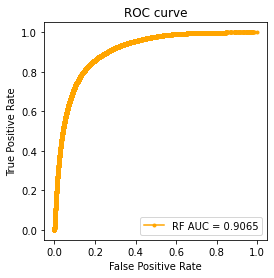

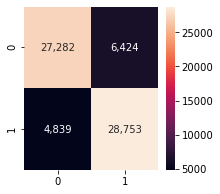

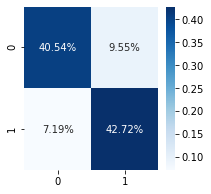

In [115]:
# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]

rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()